<a href="https://colab.research.google.com/github/markmets/muusika-minu-elus/blob/main/Tekstikas_202503_DHNB_inimhinnangud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT API abil automaatmärgendamine - HINDAMINE






#Preparation

In [ ]:
#
import pandas as pd
import numpy as np

#
from sklearn.metrics import cohen_kappa_score, classification_report

#
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 30)


# Import annotations


In [ ]:
import pandas as pd

# Define the raw URL for the Excel file
url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/human-evaluations/Inimm%C3%A4rgendused_408_1.xlsx'
annotator1 = pd.read_excel(url)

url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/human-evaluations/Inimm%C3%A4rgendused_408_2.xlsx'
annotator2 = pd.read_excel(url)

url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/human-evaluations/Inimm%C3%A4rgendused_408_3.xlsx'
annotator3 = pd.read_excel(url)

#remove empty columns
annotator1 = annotator1.dropna(axis=1, how='all')
annotator2 = annotator2.dropna(axis=1, how='all')
annotator3 = annotator3.dropna(axis=1, how='all')

# Define a mapping dictionary with translations
rename_dict = {
    "Lause": "Sentence",
    "3. Teema": "Theme",
    "4. Suhe": "Activity",
    "5. Suhestumise perspektiiv": "Perspective",
    "6. Suhtumise emotsioon": "Emotion",
    "8. Olukord": "Situation",
    "9. Seos ea võis sooga": "Age_reference"
}

# Apply the renaming to all three DataFrames
annotator1.rename(columns=rename_dict, inplace=True)
annotator2.rename(columns=rename_dict, inplace=True)
annotator3.rename(columns=rename_dict, inplace=True)

# Display the first few rows of the DataFrame
(annotator1.head())


,Sentence,Theme,Activity,Perspective,Emotion,Situation,Age_reference
0,"""Mullu mina muidu karjas käisin, mullu mina karjas käisin.. ""ja kooli ajal j...","laulmine, muusik",tegemine,ise,mitmetähenduslik,kool,"kooliiga, täisiga"
1,"""Untsakate "", ""Vennaskonna ""J. M. K. E laule, vahel ikka enda laule ka, et o...","laulmine, muusik","tegemine, loomine",ise,neutraalne,kontsert,NaN
2,"1990 kohtasin oma tulevast abikaasat, kes õppis näitlejaks ja võlus mind oma...",pill,"kuulamine, tegemine, meeldimine","ise, teine",positiivne,NaN,noorus
3,20 aasta hiljem on ta ise Viljandi folgil iga-aastane esineja.,"elav, abstraktne",tegemine,teine,neutraalne,kontsert,täisiga
4,4. klassis sain NSV Liidu hümni laulmise eest hinde 5.,laulmine,õppimine,ise,mitmetähenduslik,kool,kooliiga


In [ ]:
annotator3.Emotion.value_counts()

,count
Emotion,
positiivne,191
neutraalne,151
negatiivne,36
mitmetähenduslik,29


In [ ]:
annotator2.Emotion.value_counts()

,count
Emotion,
positiivne,181
neutraalne,126
negatiivne,59
mitmetähenduslik,40


In [ ]:
annotator1.Emotion.value_counts()

,count
Emotion,
neutraalne,239
positiivne,108
mitmetähenduslik,36
negatiivne,25


#Calculate kappa (exact matches)
Considers the difference in multilabel order

In [ ]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score

# Helper function to normalize annotation values
def normalize_label(label):
    if isinstance(label, list):
        return tuple(sorted(label))
    return label

# Define the annotation columns (excluding "Sentence")
columns = ["Theme", "Activity", "Perspective", "Emotion", "Situation", "Age_reference"]

# Create a dictionary to collect metrics for each annotation column
data = {}

for col in columns:
    # Create new Series for each annotator for the current column, filling NaNs with "NONE"
    ann1 = annotator1[col].fillna("NONE").apply(normalize_label)
    ann2 = annotator2[col].fillna("NONE").apply(normalize_label)
    ann3 = annotator3[col].fillna("NONE").apply(normalize_label)

    # Calculate pairwise Cohen's kappa scores and accuracy scores
    data[col] = {
       'kappa_annotator1_vs_annotator2': cohen_kappa_score(ann1, ann2),
       'kappa_annotator1_vs_annotator3': cohen_kappa_score(ann1, ann3),
       'kappa_annotator2_vs_annotator3': cohen_kappa_score(ann2, ann3),
       'accuracy_annotator1_vs_annotator2': accuracy_score(ann1, ann2),
       'accuracy_annotator1_vs_annotator3': accuracy_score(ann1, ann3),
       'accuracy_annotator2_vs_annotator3': accuracy_score(ann2, ann3)
    }

# Convert dictionary to a DataFrame with annotation columns as rows
df = pd.DataFrame(data).T.reset_index().rename(columns={'index': 'Category'})

# Add new columns for average kappa and average accuracy for each row
kappa_cols = ['kappa_annotator1_vs_annotator2', 'kappa_annotator1_vs_annotator3', 'kappa_annotator2_vs_annotator3']
accuracy_cols = ['accuracy_annotator1_vs_annotator2', 'accuracy_annotator1_vs_annotator3', 'accuracy_annotator2_vs_annotator3']

df['avg_kappa'] = df[kappa_cols].mean(axis=1)
df['avg_accuracy'] = df[accuracy_cols].mean(axis=1)

# Calculate overall averages across all annotation columns (for each metric)
overall = {
    'Category': 'Average',
    'kappa_annotator1_vs_annotator2': df['kappa_annotator1_vs_annotator2'].mean(),
    'kappa_annotator1_vs_annotator3': df['kappa_annotator1_vs_annotator3'].mean(),
    'kappa_annotator2_vs_annotator3': df['kappa_annotator2_vs_annotator3'].mean(),
    'accuracy_annotator1_vs_annotator2': df['accuracy_annotator1_vs_annotator2'].mean(),
    'accuracy_annotator1_vs_annotator3': df['accuracy_annotator1_vs_annotator3'].mean(),
    'accuracy_annotator2_vs_annotator3': df['accuracy_annotator2_vs_annotator3'].mean(),
    'avg_kappa': df['avg_kappa'].mean(),
    'avg_accuracy': df['avg_accuracy'].mean()
}

# Append the overall averages as a new row
df = pd.concat([df, pd.DataFrame([overall])], ignore_index=True)

# Save the resulting table to an Excel file
df.to_excel("kappa_accuracy_exact_matches.xlsx", index=False)

print("Kappa and accuracy for exact matches:")
(df)


Kappa and accuracy for exact matches:


,Category,kappa_annotator1_vs_annotator2,kappa_annotator1_vs_annotator3,kappa_annotator2_vs_annotator3,accuracy_annotator1_vs_annotator2,accuracy_annotator1_vs_annotator3,accuracy_annotator2_vs_annotator3,avg_kappa,avg_accuracy
0,Theme,0.464023,0.498961,0.458660,0.512255,0.553922,0.509804,0.473881,0.525327
1,Activity,0.583656,0.604144,0.596551,0.651961,0.674020,0.669118,0.594784,0.665033
2,Perspective,0.512166,0.530800,0.554428,0.664216,0.678922,0.674020,0.532465,0.672386
3,Emotion,0.437548,0.462575,0.519698,0.615196,0.651961,0.683824,0.473274,0.650327
4,Situation,0.663161,0.700731,0.708840,0.774510,0.808824,0.806373,0.690911,0.796569
5,Age_reference,0.404737,0.570907,0.553899,0.779412,0.875000,0.813725,0.509848,0.822712
6,Average,0.510882,0.561353,0.565346,0.666258,0.707108,0.692810,0.545860,0.688725


# Calculate F1 (considers partial matches)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd

def process_response(response):
    """Convert a response string into a set of normalized choices.
       If the response is "NONE", return an empty set.
    """
    if response == "NONE":
        return set()
    return {choice.strip().lower() for choice in response.split(",") if choice.strip()}

multi_label_columns = ["Theme", "Activity", "Perspective", "Emotion", "Situation", "Age_reference"]

f1_results = {}

for col in multi_label_columns:
    responses_1 = [process_response(str(val)) for val in annotator1[col].fillna("NONE")]
    responses_2 = [process_response(str(val)) for val in annotator2[col].fillna("NONE")]
    responses_3 = [process_response(str(val)) for val in annotator3[col].fillna("NONE")]

    # Get the union of labels for consistent binarization
    all_labels = set().union(*responses_1, *responses_2, *responses_3)

    # Use MultiLabelBinarizer with a fixed set of classes
    mlb = MultiLabelBinarizer(classes=list(all_labels)) if all_labels else MultiLabelBinarizer()
    y1 = mlb.fit_transform(responses_1)
    y2 = mlb.transform(responses_2)
    y3 = mlb.transform(responses_3)

    # Compute F1 score for each pair, setting zero_division=1 so that rows with no labels return 1
    f1_1_2 = f1_score(y1, y2, average="weighted", zero_division=1)
    f1_1_3 = f1_score(y1, y3, average="weighted", zero_division=1)
    f1_2_3 = f1_score(y2, y3, average="weighted", zero_division=1)

    f1_results[col] = {
        'annotator1_vs_annotator2': f1_1_2,
        'annotator1_vs_annotator3': f1_1_3,
        'annotator2_vs_annotator3': f1_2_3
    }

# Convert results to a DataFrame and add a new column "Averages"
f1_results_df = pd.DataFrame.from_dict(f1_results, orient='index').reset_index().rename(columns={'index': 'Category'})
f1_results_df["avg_f1"] = f1_results_df[["annotator1_vs_annotator2", "annotator1_vs_annotator3", "annotator2_vs_annotator3"]].mean(axis=1)

# Save the DataFrame to an Excel file
f1_results_df.to_excel("multi_label_f1_scores.xlsx", index=False)

print("Multi-label F1 Score Results Table:")
(f1_results_df)

Multi-label F1 Score Results Table:


,Category,annotator1_vs_annotator2,annotator1_vs_annotator3,annotator2_vs_annotator3,avg_f1
0,Theme,0.752118,0.742643,0.744526,0.746429
1,Activity,0.772245,0.770531,0.764110,0.768962
2,Perspective,0.776432,0.770314,0.756917,0.767888
3,Emotion,0.620957,0.652937,0.682708,0.652201
4,Situation,0.788192,0.779244,0.776140,0.781192
5,Age_reference,0.517955,0.649488,0.520588,0.562677


# Classification report

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

def f1_score_set(s1, s2):
    """Compute the F1 score between two sets."""
    if not s1 and not s2:
        return 1.0
    if not s1 or not s2:
        return 0.0
    intersection = len(s1.intersection(s2))
    precision = intersection / len(s1)
    recall = intersection / len(s2)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def process_response(response):
    """Convert a response string into a set of normalized choices.
       If the response is "NONE", return an empty set.
    """
    if response == "NONE":
        return set()
    return {choice.strip().lower() for choice in response.split(",") if choice.strip()}

# Assume your DataFrames (annotator1, annotator2, annotator3) are already loaded and renamed

# Define the multi-label columns (for example, all except "Emotion" which might be single choice)
multi_label_columns = ["Theme", "Activity", "Perspective", "Emotion", "Situation", "Age_reference"]

# Define the annotator pairs to compare, along with short names for the Excel sheet names
annotator_pairs = [
    ("annotator1", annotator1, "annotator2", annotator2),
    ("annotator1", annotator1, "annotator3", annotator3),
    ("annotator2", annotator2, "annotator3", annotator3)
]

# Mapping of annotator names to short names
short_names = {
    "annotator1": "ann1",
    "annotator2": "ann2",
    "annotator3": "ann3"
}

# Dictionary to store classification reports (each report will be stored as a DataFrame)
reports_dfs = {}

for col in multi_label_columns:
    for name1, df1, name2, df2 in annotator_pairs:
        # Process responses for each annotator for the current column
        responses1 = [process_response(str(x)) for x in df1[col].fillna("NONE")]
        responses2 = [process_response(str(x)) for x in df2[col].fillna("NONE")]

        # Fit MultiLabelBinarizer on the union of both annotators' responses
        all_responses = responses1 + responses2
        mlb = MultiLabelBinarizer()
        mlb.fit(all_responses)

        # Transform both sets of responses
        y_true = mlb.transform(responses1)
        y_pred = mlb.transform(responses2)

        # Compute the classification report; using zero_division=0 avoids errors when some labels are missing.
        report_dict = classification_report(
            y_true,
            y_pred,
            target_names=mlb.classes_,
            zero_division=0,
            output_dict=True
        )

        # Convert the report dictionary to a DataFrame and transpose it for easier viewing
        report_df = pd.DataFrame(report_dict).transpose()

        # Create a unique key name for this report using short annotator names
        sheet_key = f"{col}_{short_names[name1]}_vs_{short_names[name2]}"
        # No need to trim since these should be within the limit.
        reports_dfs[sheet_key] = report_df

# Save all reports to an Excel file with one sheet per report
with pd.ExcelWriter("classification_reports.xlsx") as writer:
    for sheet_name, df_report in reports_dfs.items():
        df_report.to_excel(writer, sheet_name=sheet_name)

print("Classification reports have been saved to 'classification_reports.xlsx'.")


Classification reports have been saved to 'classification_reports.xlsx'.


# Vead

In [ ]:
import pandas as pd

# List of columns to compare.
multi_label_columns = ["Theme", "Activity", "Perspective", "Emotion", "Situation", "Age_reference"]

# Dictionary mapping annotator names to their DataFrames.
annotators = {
    "annotator1": annotator1,
    "annotator2": annotator2,
    "annotator3": annotator3
}

# List of annotator pairs.
pairs = [("annotator1", "annotator2"),
         ("annotator1", "annotator3"),
         ("annotator2", "annotator3")]

def process_value(val):
    """
    Convert a value to a set of stripped elements.
    - If val is a list, tuple, or set, convert each element to a string and strip it.
    - If it's a string, split on commas and strip each element.
    - If val is NaN or empty, return an empty set.
    """
    if pd.isna(val):
        return set()
    if isinstance(val, (list, tuple, set)):
        return {str(item).strip() for item in val if str(item).strip()}
    if isinstance(val, str):
        val = val.strip()
        if val == "":
            return set()
        return {item.strip() for item in val.split(",") if item.strip()}
    # For any other type, convert to string.
    s = str(val).strip()
    return {s} if s else set()

# For each multi-label column, create an Excel file.
for col in multi_label_columns:
    output_file = f"Comparison_{col}.xlsx"
    with pd.ExcelWriter(output_file) as writer:
        # For each annotator pair, merge on "Sentence" and compare the specific column.
        for pair in pairs:
            annot1_name, annot2_name = pair
            df1 = annotators[annot1_name][["Sentence", col]]
            df2 = annotators[annot2_name][["Sentence", col]]

            # Merge on "Sentence" with suffixes identifying the annotator.
            df_merged = pd.merge(df1, df2, on="Sentence", suffixes=(f"_{annot1_name}", f"_{annot2_name}"))

            # Rename columns for clarity.
            col1 = f"{col}_{annot1_name}"
            col2 = f"{col}_{annot2_name}"
            df_merged.rename(columns={col1: f"{annot1_name}_{col}", col2: f"{annot2_name}_{col}"}, inplace=True)
            col1 = f"{annot1_name}_{col}"
            col2 = f"{annot2_name}_{col}"

            # Filter for mismatches:
            # 1. Process each value into a set (order-independent).
            # 2. Only include rows where the sets differ and at least one set is non-empty.
            mask = df_merged.apply(
                lambda row: (process_value(row[col1]) != process_value(row[col2])) and
                            bool(process_value(row[col1]) or process_value(row[col2])),
                axis=1
            )
            df_mismatch = df_merged.loc[mask, ["Sentence", col1, col2]]

            # Define a sheet name for the pair (e.g., "annotator1_vs_annotator2").
            sheet_name = f"{annot1_name}_vs_{annot2_name}"
            df_mismatch.to_excel(writer, sheet_name=sheet_name, index=False)
    print(f"Hindamisvead_inimhindajad'{col}' saved to {output_file}")


Hindamisvead_inimhindajad'Theme' saved to Comparison_Theme.xlsx
Hindamisvead_inimhindajad'Activity' saved to Comparison_Activity.xlsx
Hindamisvead_inimhindajad'Perspective' saved to Comparison_Perspective.xlsx
Hindamisvead_inimhindajad'Emotion' saved to Comparison_Emotion.xlsx
Hindamisvead_inimhindajad'Situation' saved to Comparison_Situation.xlsx
Hindamisvead_inimhindajad'Age_reference' saved to Comparison_Age_reference.xlsx


# Analüüs

# Visualiseeri

In [ ]:
dfMasinhinnangud_puhas = dfMasinhinnangud.dropna()
dfMasinhinnangud_puhas = dfMasinhinnangud_puhas[dfMasinhinnangud_puhas['seostub'] == "jah"]

dfMasinhinnangud_puhas

,ID,Esitusaeg,Sünniaasta,Sugu,Kool/tegevusala,Tekst_ilmakys,Sünniaasta_grupp,Lause,Tekst_index,ID_lause,Random_ID,lausestus,seostub,teema,tegevus,isik,hoiak
1,K113,2022-12-08,1973,m,-,Mind ei huvita muusika enam. Ma olen olnud umbes alates 10-aastasest peale k...,vanem,Üksinda purjus peaga tulevad mõnikord mingid sõnad mingi rütmiga pähe ja vah...,0,189,0.000173,õige,jah,laulmine,tegemine,ise,neutraalne
2,K104,2022-10-05,1981,n,-,Olen muusikakoolis õppinud viiulit mängima 8 aastat. Samuti käisin laulukoor...,vanem,"See sisaldas lugusid nagu U2 ""If God Will Send His Angels ""(see oli samal aj...",5,1378,0.000333,õige,jah,salvestatud,kuulamine,ise,positiivne
3,K108,2022-10-20,1968,n,Kodune,"Olen lapsena Tallinna Muusikakeskkoolis õppinud klaverit, alates 5.klassist ...",vanem,"Suudan natuke mängida klaverit, akordioni, harmooniumi.",8,1984,0.000663,õige,jah,pill,tegemine,ise,neutraalne
5,K108,2022-10-20,1968,n,Kodune,"Olen lapsena Tallinna Muusikakeskkoolis õppinud klaverit, alates 5.klassist ...",vanem,"Meenub mu isa mälestus, kuidas ta oli ""survestanud ""oma ema endale akordioni...",8,2258,0.000879,õige,jah,pill,tegemine,teine,neutraalne
6,K106,2022-11-13,1981,n,Eesti Kunstiakadeemia /tekstiilikunst; Tallinna Ülikool/kultuurikorraldus,"Olen ""Kontsi""(praegune Muusikaakadeemia) haridusega koorijuhist koorilaulja,...",vanem,"Või Telliskivi keskväljaku kunstmuruväljak, kus on esinenud nii NOEP kui tür...",7,1890,0.001523,õige,jah,kontsert,ei,umb,neutraalne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5073,K111,2022-12-17,2006,n,Heino Elleri Muusikakool,"Olen pillimees. Kuulan väga palju muusikat, sellest tulenevalt on mulle palj...",noorem,"Mäletan, kuidas ühel muusikakooli ettemängul mängisin klassikalise loo aseme...",11,2885,0.998090,õige,jah,pill,tegemine,ise,neutraalne
5075,K120,2022-12-19,2009,m,Räpina Ühisgümnaasium,"Mul on suhe muusikaga väga väike, sest ma ei mängi pilli üldse ja kuulan muu...",noorem,"Inimest iseloomustab rahulik muusika, rock muusika jne.",18,3469,0.998526,õige,jah,abstraktne,kuulamine,umb,neutraalne
5076,K109,2022-11-25,1974,m,kirjanik ja tõlkija,"Ma olen kuulus laulja, kes on kuulus sellega, et ei oska laulda. Aga lapsena...",vanem,Näiteks Tanja Mihhailovast kui lauljast ei teadnud ma suurt midagi enne kui ...,9,2423,0.998616,õige,jah,laulmine,kuulamine,teine,neutraalne
5080,K163,2022-12-20,2007,n,Räpina Ühisgümnaasium õpilane,Vabalajal meeldib kuulata muusikat ning ise käin laulmas ansamblis. Meeldiva...,noorem,Näiteks paljude noorte lemmik 5-miinust.,61,5036,0.999539,õige,jah,bänd,ei,umb,neutraalne


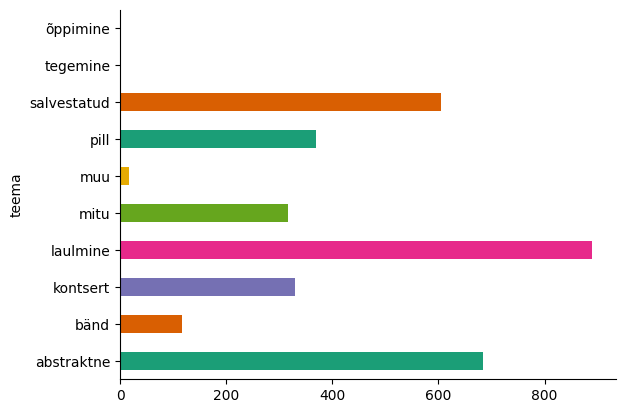

In [ ]:
#KATEGOORIATE TULPDIAGRAMM
dfMasinhinnangud_puhas.groupby('teema').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

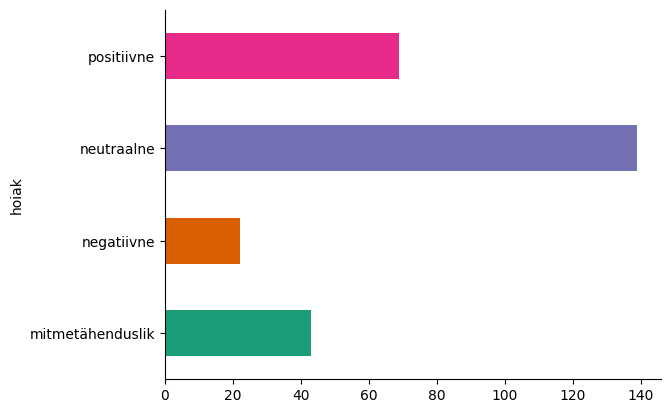

In [ ]:
#TONAALSUSTE TULPDIAGRAMM
dfHinnangud1.groupby('hoiak').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

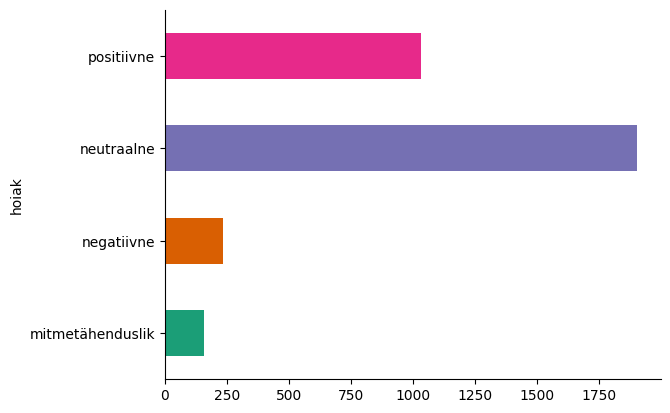

In [ ]:
#TONAALSUSTE TULPDIAGRAMM
dfMasinhinnangud_puhas.groupby('hoiak').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

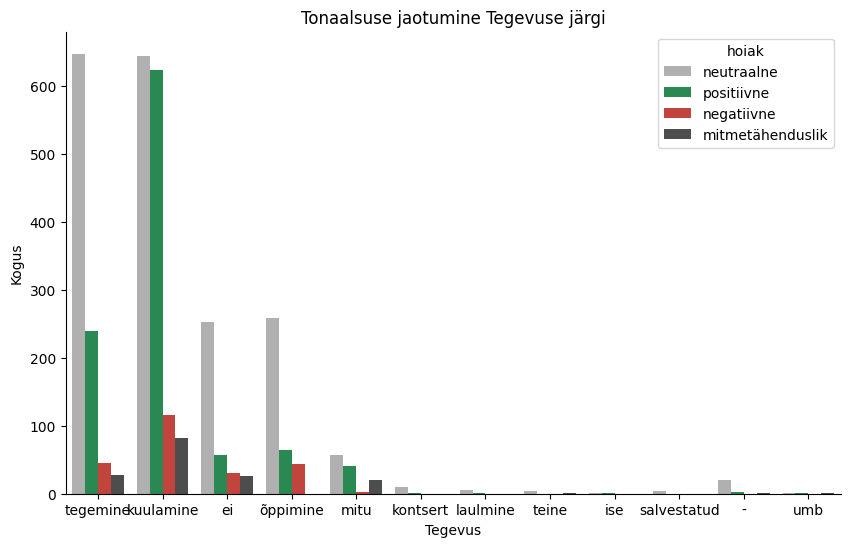

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom palette for 'hoiak'
custom_palette = {
    'negatiivne': '#D73027',  # Reddish for negative
    'positiivne': '#1A9850',  # Greenish for positive
    'neutraalne': '#B0B0B0',  # Dark gray for neutral
    'mitmetähenduslik': '#4D4D4D'  # Beige for ambiguous
}

plt.figure(figsize=(10, 6))

# Create the count plot with the custom palette
sns.countplot(data=dfMasinhinnangud_puhas, x='tegevus', hue='hoiak', palette=custom_palette)

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Add axis labels and title
plt.xlabel('Tegevus')
plt.ylabel('Kogus')
plt.title('Tonaalsuse jaotumine Tegevuse järgi')

# Show the plot
plt.show()


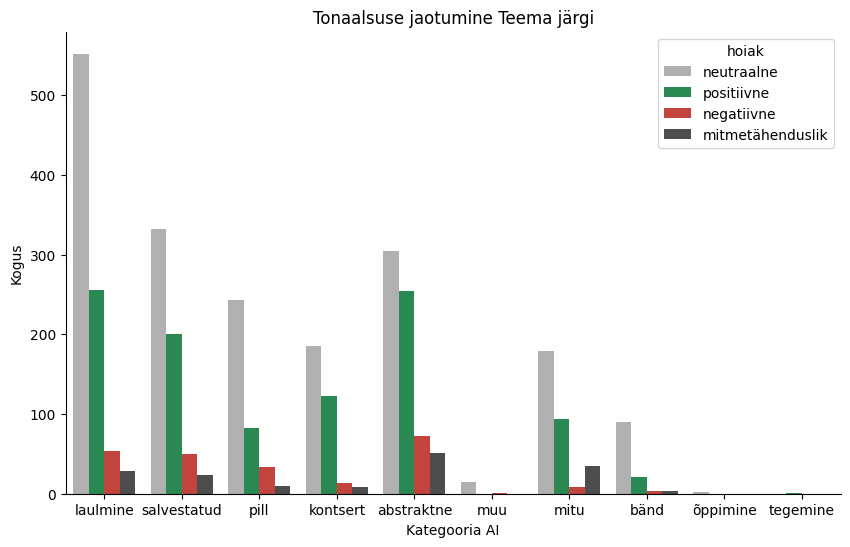

In [ ]:
#TONAALSUSED + KATEGOORIAD TULPDIAGRAMM
#kuidas tonaalsused kategooriate kaupa jaotuvad
custom_palette = {
    'negatiivne': '#D73027',  # Reddish for negative
    'positiivne': '#1A9850',  # Greenish for positive
    'neutraalne': '#B0B0B0',  # Dark gray for neutral
    'mitmetähenduslik': '#4D4D4D'  # Beige for ambiguous
}


plt.figure(figsize=(10, 6))

# Loo loendusdiagramm, millel on 'kategooria_AI' x-teljel ja 'tonaalsus_AI' varjundina
sns.countplot(data=dfMasinhinnangud_puhas, x='teema', hue='hoiak', palette=custom_palette)

# Eemalda ülemised ja paremad raamijoone osad
plt.gca().spines[['top', 'right']].set_visible(False)

# Lisa telje sildid ja pealkiri
plt.xlabel('Kategooria AI')
plt.ylabel('Kogus')
plt.title('Tonaalsuse jaotumine Teema järgi')

# Kuva diagramm
plt.show()